# Intro

This notebook is to calcuate ATLN and ENSO indices and get a list of years for the phase of each on the CESM LENS2 project

how the models show the pattern differences

how variability has been changing between 

regression with precip GPCP version 2.3 1979-2020

# Imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import xeofs as xe
import glob
from geocat.viz import util as gvutil
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

C:\Users\allan\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\allan\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\allan\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


# PBSClustter

In [ ]:
# Create a PBS cluster object
cluster = PBSCluster(account='P93300313',
                     job_name='ATLN-ENSO-CESMLE2',
                     cores=1,
                     memory='8GiB',
                     processes=1,
                     walltime='02:00:00',
                     queue='casper',
                     interface='ext',
                     n_workers=1)

# dont scale unless using LE
# cluster.scale(10)

client = Client(cluster)
client

In [ ]:
cluster.scale(2)

In [ ]:
# client.shutdown

# Useful functions

In [201]:
def ds_map(ds_to_plt, bounds=[20, -60, 10, -10], name='figure'):
    fig, ax = plt.subplots(1, 1,
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, ds_to_plt.longitude)

    ax.set_title(name)
    lat_ticks = np.arange(bounds[3], bounds[2], 5)
    lon_ticks = np.arange(bounds[1], bounds[0], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)

    
    def resize_colobar(event):
        plt.draw()
        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])
        
    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, ds_to_plt.latitude, cdat,
                              levels=np.arange(-0.4, 0.5, 0.05),
                              # levels=40,
                              transform=ccrs.PlateCarree(), cmap='inferno', extend='both')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)
    resize_colobar(None)
    # plt.savefig(name, dpi=300)
    plt.show()


def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended


def index_plot(ds1, ds2=[None], name1='', name2='', threshold=0.5):
    lim = 4 * threshold
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(ds1.time, ds1, color='black', label=name1)
    gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)
    
    gvutil.set_axes_limits_and_ticks(ax, ylim=(-1*lim, lim))
    ax.fill_between(ds1.time, ds1, y2=-threshold,
                    where=ds1 < -threshold, color='blue', interpolate=True)
    ax.fill_between(ds1.time, ds1, y2=threshold,
                    where=ds1> threshold, color='red', interpolate=True)
    plt.title(f'{name1}{name2}')
    ax.set_xlabel('year', fontsize=24)
    plt.grid()
    plt.show()

# Data Imports

## SST

In [215]:
# files = glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/SST/*.nc')
# start with hadisst files
ds = xr.open_dataset('HadISST_sst.nc.gz').compute()
ds

<xarray.Dataset> Size: 482MB
Dimensions:    (time: 1861, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 15kB 0.0 31.0 31.0 ... 5.661e+04 5.664e+04
    sst        (time, latitude, longitude) float32 482MB -1e+03 -1e+03 ... nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    3/3/2025 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

## precip

In [222]:
files = glob.glob('*.nc4')
precip = xr.open_mfdataset(files, engine='netcdf4')
precip = precip['sat_gauge_precip']
precip

<xarray.DataArray 'sat_gauge_precip' (time: 35, lat: 360, lon: 720)> Size: 36MB
dask.array<concatenate, shape=(35, 360, 720), dtype=float32, chunksize=(1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 3kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 280B 1983-01-01 1983-02-01 ... 1985-11-01
Attributes:
    units:         mm/day
    long_name:     combined satellite-gauge precipitation
    valid_range:   [  0. 100.]
    cell_methods:  time: mean

# select data

In [231]:
# selected dates
dates = xr.date_range(start='1920-01-16', end='2025-01-16', freq='1ME')
# dates = xr.date_range(start='1970-01-16', end='2022-01-16', freq='1ME')
ds = ds.sel(time=dates, method='nearest')

# select summer
# summer_ds = ds.where(ds['time'].dt.month.isin([6, 7, 8]), drop=True)

In [110]:
# ATL area
ATL_hadisst = ds['sst'].sel(latitude=slice(10, -10), longitude=slice(-60, 20)).compute()

# ENSO34 area
ENSO34_hadisst = ds['sst'].sel(latitude=slice(5, -5), longitude=slice(-170, -120)).compute()

# ATLN and ENSO indices

## ONI Index

In [26]:
# get weighted latitudes
weights = np.cos(np.deg2rad(ENSO34_hadisst.latitude))
weights.name = "weights"

In [27]:
ENSO34_clim = ENSO34_hadisst.groupby(ENSO34_hadisst['time'].dt.month).mean(dim='time').compute()
ENSO34_anom = ENSO34_hadisst.groupby(ENSO34_hadisst['time'].dt.month) - ENSO34_clim
# all anomaly fields were linearly detrended zhang et al
ENSO34_anom_dtrend = detrend_dim(ENSO34_anom, dim='time')

In [28]:
ENSO34_roll = ENSO34_anom_dtrend.rolling(time=3, center=True).mean()
ENSO34_index = ENSO34_roll.mean(('longitude', 'latitude'), skipna=True).compute()

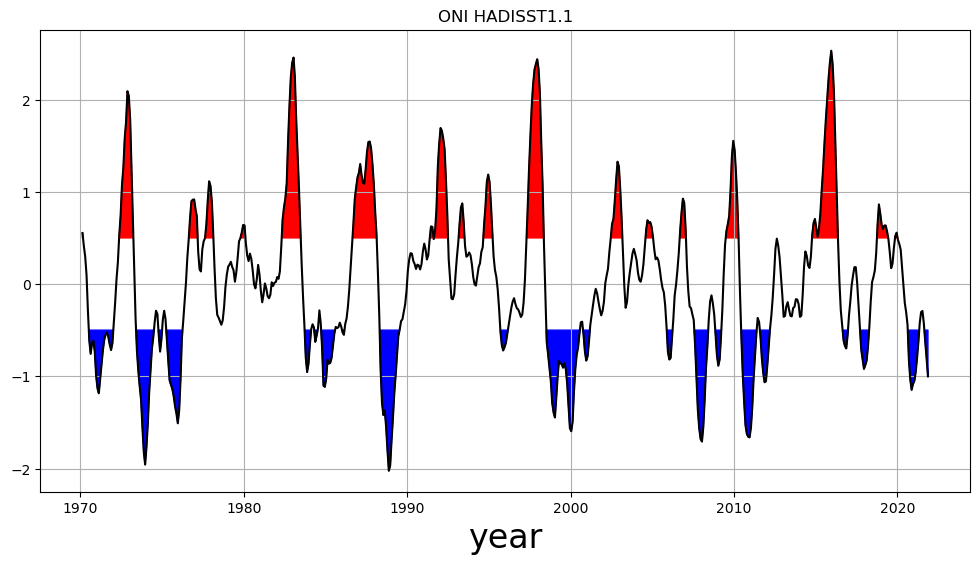

In [29]:
# index plot
fig, ax = plt.subplots(figsize=(12,6))

threshold = 0.5

ax.plot(ENSO34_index.time, ENSO34_index, color='black')
# gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

# gvutil.set_axes_limits_and_ticks(ax,ylim=(-2., 2.))
ax.fill_between(ENSO34_index.time, ENSO34_index,
                y2=-threshold, where=ENSO34_index < -threshold,
                color='blue', interpolate=True)
ax.fill_between(ENSO34_index.time, ENSO34_index,
                y2=threshold, where=ENSO34_index > threshold,
                color='red', interpolate=True)

plt.title('ONI HADISST1.1')
ax.set_xlabel('year', fontsize=24)
plt.grid()
plt.show()

## clim and anomalies

In [111]:
# the mistake was missing the groupby function
# all year
ATL_clim = ATL_hadisst.groupby(ATL_hadisst['time'].dt.month).mean(dim='time').compute()
ATL_anom_pm = ATL_hadisst.groupby(ATL_hadisst['time'].dt.month) - ATL_clim

# all anomaly fields were linearly detrended
ATL_anom_dtrend = detrend_dim(ATL_anom_pm, dim='time')

### EOFa

In [112]:
model = xe.single.EOF(n_modes=3, use_coslat=False)
# all year climatologies of all data
model.fit(ATL_anom_dtrend, dim='time')

In [113]:
components = model.components()

In [114]:
xplained_var = model.explained_variance_ratio().values

In [115]:
# scale by PC std
# nomalized in this package is L2 norm not STD
PCs = model.scores(normalized=False)

# normalized by l2norm true as test
# PCs = model.scores()

pc_std = PCs.std()
pc_mean = PCs.mean()

normalized_PCs = (PCs - pc_mean)/ pc_std
scaled_EOF = components * pc_std

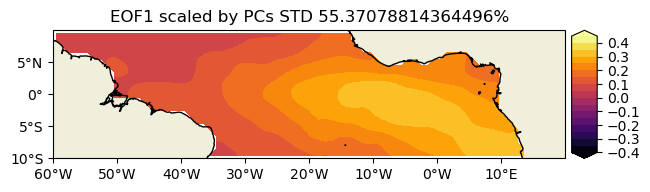

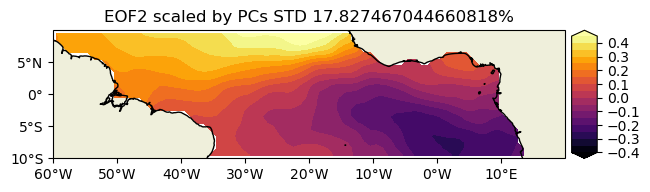

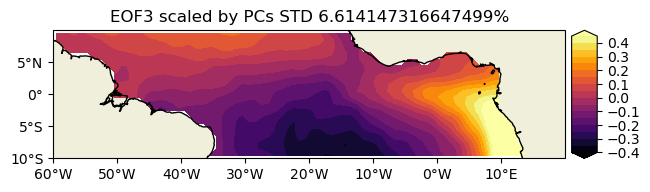

In [133]:
j=0
for i in scaled_EOF['mode'].values:
    mode = scaled_EOF.sel(mode=i)
    ds_map(mode, name=f'EOF{i} scaled by PCs STD {xplained_var[j] * 100 }%')
    j+=1

In [117]:
PC1 = normalized_PCs.sel(mode=1)
PC2 = normalized_PCs.sel(mode=2)
PC3 = normalized_PCs.sel(mode=3)
# PC4 = normalized_PCs.sel(mode=4)
# PC5 = normalized_PCs.sel(mode=5)

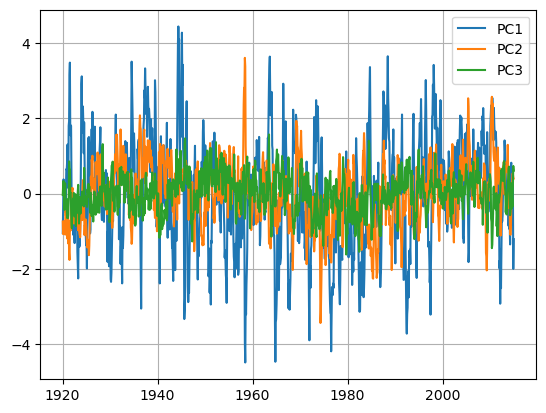

In [119]:
plt.plot(PC1.time, PC1, label='PC1')
plt.plot(PC2.time, PC2, label='PC2')
plt.plot(PC3.time, PC3, label='PC3')
# plt.plot(PC4.time, PC4, label='PC4')
# plt.plot(PC5.time, PC5, label='PC5')
plt.legend()
plt.grid()
plt.show()

## EOF differences

In [120]:
EATL = (components.sel(mode=1) + components.sel(mode=3)) / (2 ** 0.5)
CATL = (components.sel(mode=1) - components.sel(mode=3)) / (2 ** 0.5)

In [121]:
EATLs = (scaled_EOF.sel(mode=1) + scaled_EOF.sel(mode=3)) / (2 ** 0.5)
CATLs = (scaled_EOF.sel(mode=1) - scaled_EOF.sel(mode=3)) / (2 ** 0.5)

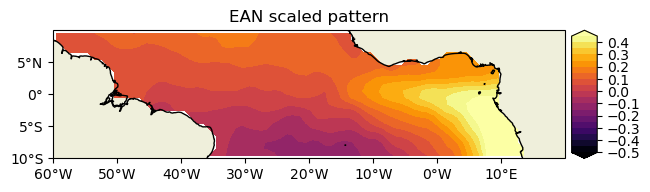

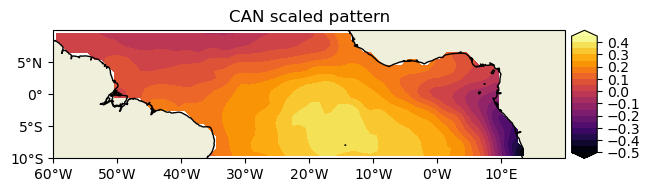

In [131]:
# ds_map(EATL, name=f'EAN pattern')
# ds_map(CATL, name=f'CAN pattern')
ds_map(EATLs, name=f'EAN scaled pattern')
ds_map(CATLs, name=f'CAN scaled pattern')

## CANI and EANI

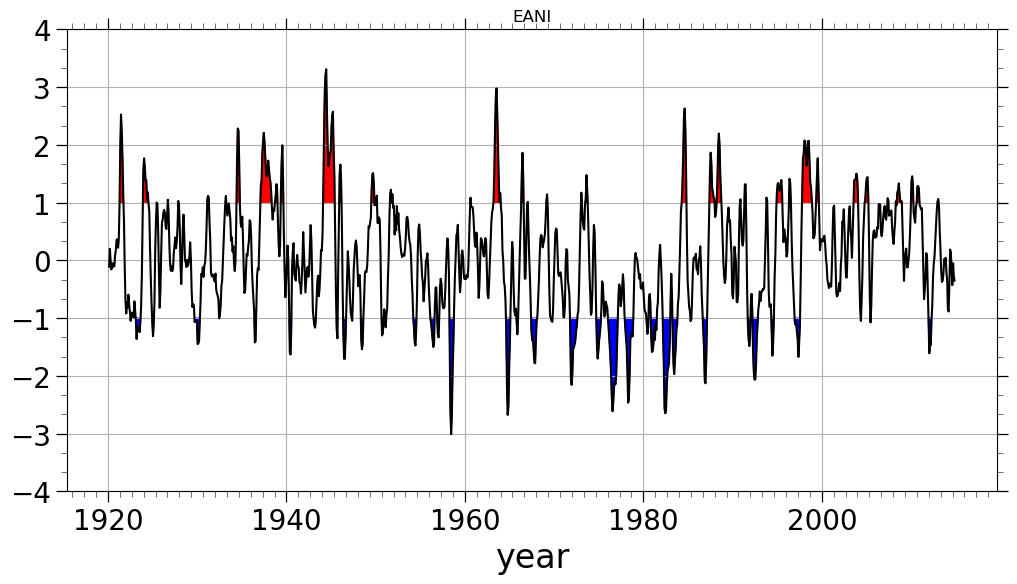

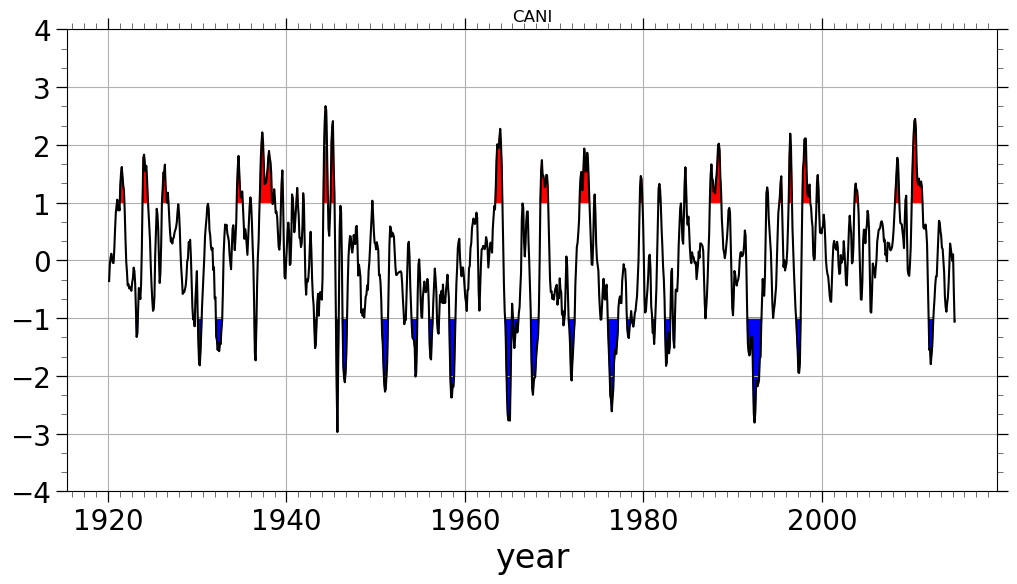

In [202]:
EANI = (PC1 + PC3) / (2 ** 0.5)
CANI = (PC1 - PC3) / (2 ** 0.5)
# ENSO34_roll = ENSO34_anom_dtrend.rolling(time=3, center=True).mean()
# ENSO34_index = ENSO34_roll.mean(('longitude', 'latitude'), skipna=True).compute()
EANI_roll = EANI.rolling(time=3, center=True).mean()
CANI_roll = CANI.rolling(time=3, center=True).mean()

index_plot(EANI_roll, name1='EANI', threshold=1)
index_plot(CANI_roll, name2='CANI', threshold=1)

In [232]:
EANI_s = EANI_roll.where(EANI['time.season'] == 'JJA')
CANI_s = CANI_roll.where(CANI['time.season'] == 'JJA')

EANI_p = np.unique(EANI_s.where(EANI >= 1, drop=True).time.dt.year)
EANI_n = np.unique(EANI_s.where(EANI <= 1, drop=True).time.dt.year)
CANI_p = np.unique(CANI_s.where(CANI >= 1, drop=True).time.dt.year)
CANI_n = np.unique(CANI_s.where(CANI >= 1, drop=True).time.dt.year)

print(f'EANI positive: {EANI_p}')
print(f'EANI negative: {EANI_n}')
print(f'CANI positive: {CANI_p}')
print(f'CANI negative: {CANI_n}')

EANI positive: [1921 1923 1924 1925 1926 1927 1928 1931 1933 1934 1937 1938 1939 1942
 1944 1945 1946 1949 1950 1951 1952 1960 1963 1964 1966 1967 1969 1971
 1972 1973 1984 1987 1988 1989 1990 1991 1993 1994 1995 1996 1997 1998
 1999 2001 2002 2003 2004 2005 2006 2007 2008 2010 2012 2013]
EANI negative: [1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]
CANI positive: [1920 1921 1923 1924 1925 1926 1927 1931 1934 1935 1936 1937 1938 1939
 1940 1941 1944 1945 1946 1947 1949 1961 1963 1964 1966 1968 1969 1972
 1973 1974 1979 1981 1984 1987 1988 1989 1993 1995 1996

## Variability

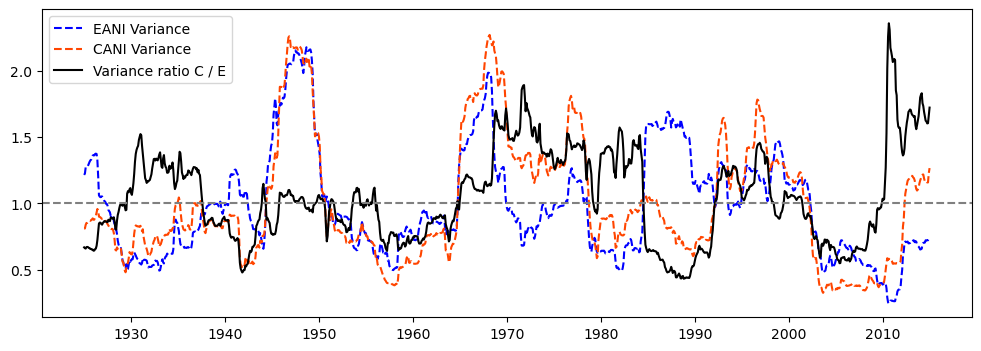

In [200]:
EANI_var = EANI.rolling(time=60).var()
CANI_var = CANI.rolling(time=60).var()
CvE_r = CANI_var / EANI_var

plt.figure(figsize=(12, 4))
plt.plot(EANI_var.time[:], EANI_var[:], label='EANI Variance', color='blue', linestyle='--')
plt.plot(CANI_var.time[:], CANI_var[:], label='CANI Variance', color='orangered', linestyle='--')
plt.plot(CvE_r.time, CvE_r, label='Variance ratio C / E', color='black')
plt.axline((0, 1), slope=0, color='gray', linestyle='--')
plt.legend()
plt.show()

# Precipitation

## JJA

In [ ]:
# select summer
# summer_ds = precip.where(ds['time'].dt.month.isin([6, 7, 8]), drop=True)